In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 

# For colorspace conversions in the last section
from skimage.color import rgb2lab,lab2rgb
from skimage.transform import rescale

# Create the futhark instance
from mean_shift import mean_shift
fut = mean_shift()

/home/mathis/.local/lib/python3.10/site-packages/pyopencl/__init__.py:272: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


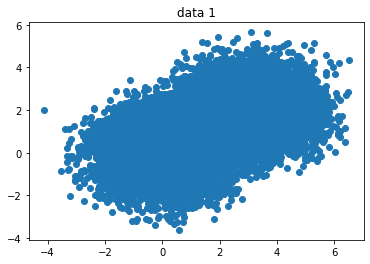

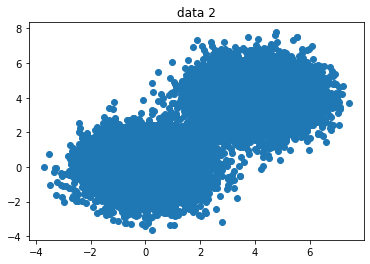

In [3]:
# Create the random points
data1 = np.concatenate((
    np.random.normal(loc = (0, 0), scale = (1, 1), size = (10000, 2)),
    np.random.normal(loc = (3, 2), scale = (1, 1), size = (10000, 2))
)).astype(np.float32)
data2 = np.concatenate((
    np.random.normal(loc = (0, 0), scale = (1, 1), size = (10000, 2)),
    np.random.normal(loc = (4, 4), scale = (1, 1), size = (10000, 2))
)).astype(np.float32)

# Plot the points
plt.title("data 1")
plt.scatter(data1[:, 0], data1[:, 1])
plt.show()

plt.title("data 2")
plt.scatter(data2[:, 0], data2[:, 1])
plt.show()


In [4]:
# We can try to make it so that the distance between the two clusters is the same along each axis (X and Y),
# and make sigma smaller than the distance between the means (so that we can still seperate the clusters).
# I thus chose half of the distance between the means, along each axis.
sigma1 = np.array([1.5, 1], dtype = np.float32)
sigma2 = np.array([2, 2], dtype = np.float32)

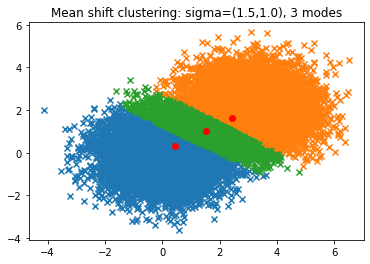

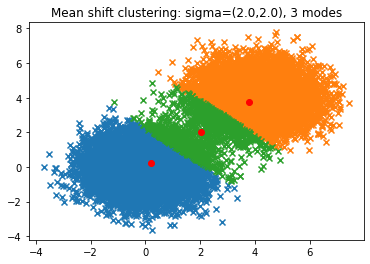

In [5]:
def visualize_clustering(data, sigma):
    modes, labels = fut.cluster_2D(data, sigma)
    modes, labels = modes.get(), labels.get()
    for k in range(len(modes)):
        data_k = np.array([data[i] for i in range(len(data)) if labels[i] == k])
        plt.scatter(data_k[:, 0], data_k[:, 1], marker = 'x')
    plt.scatter(modes[:, 0], modes[:, 1], c = 'r', marker = 'o')
    plt.title("Mean shift clustering: sigma=(%.1f,%.1f), %d modes" % (sigma[0], sigma[1], len(modes)))
    plt.show()
    
visualize_clustering(data1, sigma1)
visualize_clustering(data2, sigma2)

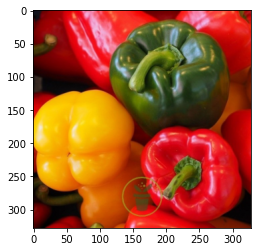

In [25]:
# Load the image and visualize the lightness (L*) channel.
img_raw = plt.imread('poivrons.jpg')
img_red   = rescale(img_raw[:, :, 0], 0.5, anti_aliasing = True)
img_green = rescale(img_raw[:, :, 1], 0.5, anti_aliasing = True)
img_blue  = rescale(img_raw[:, :, 2], 0.5, anti_aliasing = True)
img_rgb = np.dstack((img_red, img_green, img_blue))
plt.imshow(img_rgb)
plt.show()

In [26]:
# Create the (NM, 5) data array
def create_features(img_lab):
    (n, m, k) = img_lab.shape
    xx, yy = np.meshgrid(np.arange(n), np.arange(m), indexing = 'ij')
    xx = xx.reshape(n * m, 1)
    yy = yy.reshape(n * m, 1)
    img_flat = img_lab.reshape(n * m, k)
    return np.concatenate((img_flat, xx, yy), axis = -1)

def segment(img_rgb, sigma):
    img_lab = rgb2lab(img_rgb)
    data = create_features(img_lab)

    modes, labels = fut.cluster_5D(data.astype(np.float32), sigma.astype(np.float32))
    modes, labels = modes.get(), labels.get()
    
    labels = labels.reshape((img_lab.shape[0], img_lab.shape[1]))
    mode_colors = modes[:, :3]

    img_seg = mode_colors[labels]
    plt.title("Segmented image (%s modes)" % len(modes))
    plt.imshow(lab2rgb(img_seg))
    plt.show()
    

In [27]:
data = create_features(rgb2lab(img_rgb)) 

# Choose values for sigma.
# For the L*, a* and b* axes I choose a fraction of the range that the values can take.
# For the x and y axes I choose a fraction of the image size.
# We want the same sigma for the a* and b* axes. We also want the same sigma for the x and y axes.
(n, m, k) = img_rgb.shape
L = 100
a = np.max(np.abs(data[:, 1]))
b = np.max(np.abs(data[:, 2]))
sigma = 0.1 * np.array([L, max(a, b), max(a, b), max(n, m), max(n, m)], dtype = np.float32)


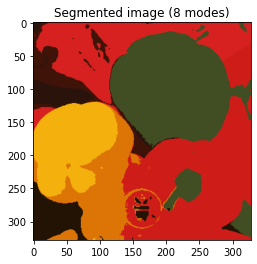

In [29]:
segment(img_rgb, sigma * 2)